<a href="https://colab.research.google.com/github/gdzqzzx/Learning-by-Doing/blob/master/Here_and_There.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting and Importing

In [ ]:
!pip install wget

import pandas as pd
import numpy as np
import sklearn
import collections
import wget
from google.colab import files
from dateutil import rrule
from datetime import datetime

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=1138948fe78836f87de537ae1bc1eb724872d37c001a60eb4e7331433b58b20d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Daily Tricks

### The Economist Audio Edition

[How to calculate difference between two dates in weeks in python](https://stackoverflow.com/questions/14191832/how-to-calculate-difference-between-two-dates-in-weeks-in-python)

In [ ]:
def getEcoAudio(year, month, day, url_only = True):
    issue_date = datetime(year, month, day)
    origin = datetime(2021, 4, 10)


    if issue_date >= origin:
        start_date = origin
        end_date = issue_date
        sign = 1
    else:
        start_date = issue_date
        end_date = origin
        sign = -1
    weeks = rrule.rrule(rrule.WEEKLY, dtstart=start_date, until=end_date)
    delta = sign * (weeks.count() - 1)

    download_url = "http://audiocdn.economist.com/sites/default/files/AudioArchive/{year}/{date}/Issue_{issue}_{date}_The_Economist_Full_edition.zip".format(
        year = str(issue_date.year),
        date = issue_date.strftime("%Y%m%d"),
        issue = str(9240+delta)
    )

    print(download_url)
    if url_only:
        return
    wget.download(download_url)
    print("Download Finished!")
    files.download(download_url.split("/")[-1])

In [ ]:
year = 2021
month = 5
day = 22

getEcoAudio(year, month, day)

http://audiocdn.economist.com/sites/default/files/AudioArchive/2021/20210522/Issue_9246_20210522_The_Economist_Full_edition.zip


# Pandas + Numpy

### 1. Split the text and assign new column names to new columns
<font size=3.5>
I want to analyze a string and split it into different rows in Excel based on conditions.

Condition 1:
Before "ATF", it's "Trustee"

Condition 2:
After "ATF", it's "Investor"

Condition 3:
If there is an "&", there are two "Trustee"

AC:
1. split the text into rows
2. no spaces before and after the string
3. Each name, assign a role
    
</font>

In [ ]:
import pandas as pd

# Construct demo input
qdf = pd.DataFrame(["Johnson & Yvonne ATF Chen Family Superannuation Fund",
                   "Tom & Jerry & Micky ATF Miaomiao",
                   "Pluto ATF Wangwang"], columns=['raw'])
# split raw text into investor part and trustee part
qdf = qdf.join(qdf['raw'].str.split("ATF", expand=True).rename(columns={0: "Trustee", 1:"Investor"}))
# split trustee part into multiple trustees
qdf = qdf.join(qdf['Trustee'].str.split("&",expand=True).add_prefix("Trustee.")).drop("Trustee", axis=1)
qdf

,raw,Investor,Trustee.0,Trustee.1,Trustee.2
0,Johnson & Yvonne ATF Chen Family Superannuatio...,Chen Family Superannuation Fund,Johnson,Yvonne,None
1,Tom & Jerry & Micky ATF Miaomiao,Miaomiao,Tom,Jerry,Micky
2,Pluto ATF Wangwang,Wangwang,Pluto,None,None


In [ ]:
qdf.stack().to_frame()

0
0 raw        Johnson & Yvonne ATF Chen Family Superannuatio...
  Investor                     Chen Family Superannuation Fund
  Trustee.0                                           Johnson 
  Trustee.1                                            Yvonne 
1 raw                         Tom & Jerry & Micky ATF Miaomiao
  Investor                                            Miaomiao
  Trustee.0                                               Tom 
  Trustee.1                                             Jerry 
  Trustee.2                                             Micky 
2 raw                                       Pluto ATF Wangwang
  Investor                                            Wangwang
  Trustee.0                                             Pluto

<font size=3.5 color=red>
    <b>Need to go further</b>: makes Trustees into multiindex
    

<font size=3.5>
    <b>Bonus:</b>
    Add condition in Trustee splitting
    
</font>
    

In [ ]:
# Solution 1

# Construct demo input
qdf = pd.DataFrame(["Johnson & Yvonne ATF Chen Family Superannuation Fund",
                    "Johnson & Yvonne Ptd Ltd ATF Chen Family Superannuation Fund",
                   "Tom & Jerry & Micky ATF Miaomiao",
                   "Pluto ATF Wangwang"], columns=['raw'])
# split raw text into investor part and trustee part
qdf = qdf.join(qdf['raw'].str.split("ATF", expand=True).rename(columns={0: "Trustee", 1:"Investor"}))
# split dataframe into with and without "Ptd Ltd"
qdf_only = qdf[qdf['Trustee'].str.contains("Ptd Ltd")].rename(columns={"Trustee":"Trustee.0"})
qdf_split = qdf[-qdf['Trustee'].str.contains("Ptd Ltd")]
# split those have "Ptd Ltd"
qdf_split = qdf_split.join(qdf_split['Trustee'].str.split("&",expand=True).add_prefix("Trustee.")).drop("Trustee", axis=1)
new_qdf = pd.concat([qdf_split, qdf_only], sort=False).reset_index(drop=True)
new_qdf.stack().to_frame()

# may be low performance when we have large dataframe

0
0 raw        Johnson & Yvonne ATF Chen Family Superannuatio...
  Investor                     Chen Family Superannuation Fund
  Trustee.0                                           Johnson 
  Trustee.1                                            Yvonne 
1 raw                         Tom & Jerry & Micky ATF Miaomiao
  Investor                                            Miaomiao
  Trustee.0                                               Tom 
  Trustee.1                                             Jerry 
  Trustee.2                                             Micky 
2 raw                                       Pluto ATF Wangwang
  Investor                                            Wangwang
  Trustee.0                                             Pluto 
3 raw        Johnson & Yvonne Ptd Ltd ATF Chen Family Super...
  Investor                     Chen Family Superannuation Fund
  Trustee.0                          Johnson & Yvonne Ptd Ltd

In [ ]:
# Solution 2

# Construct demo input
qdf = pd.DataFrame(["Johnson & Yvonne ATF Chen Family Superannuation Fund",
                    "Johnson & Yvonne Ptd Ltd ATF Chen Family Superannuation Fund",
                   "Tom & Jerry & Micky ATF Miaomiao",
                   "Pluto ATF Wangwang"], columns=['raw'])
# split raw text into investor part and trustee part
qdf = qdf.join(qdf['raw'].str.split("ATF", expand=True).rename(columns={0: "Trustee", 1:"Investor"}))
# add condition in splitting
qdf.join(qdf['Trustee'].apply(
    lambda x: pd.Series(x.split("&")) if "Ptd Ltd" not in x else pd.Series([x])).add_prefix("Trustee.")).drop("Trustee", axis=1)
# stack columns into row
qdf.stack().to_frame()

0
0 raw       Johnson & Yvonne ATF Chen Family Superannuatio...
  Trustee                                   Johnson & Yvonne 
  Investor                    Chen Family Superannuation Fund
1 raw       Johnson & Yvonne Ptd Ltd ATF Chen Family Super...
  Trustee                           Johnson & Yvonne Ptd Ltd 
  Investor                    Chen Family Superannuation Fund
2 raw                        Tom & Jerry & Micky ATF Miaomiao
  Trustee                                Tom & Jerry & Micky 
  Investor                                           Miaomiao
3 raw                                      Pluto ATF Wangwang
  Trustee                                              Pluto 
  Investor                                           Wangwang

### 2. Join multiple lists and order them by number of NaN in each row

- **20 Attributes**: id, link_to_participant_ratings, round, paper_id, group_id, justifier, justifier_display_name, question, justification, justification_id, vote_count_justification, vote_sum_justification, timestamp_justificaiton, comment, commenter, commenter_display_name, comment_id, vote_count_comment, vote_sum_comment, timestamp_comment
- **17 Attributes**: comment_id, justification_id, commenter, justification, row_id, value, vote_sum, round, paper_id, user_name, rater, timestamp, element, vote_count, question, vote, comment

- **18 Atrributes**: text unit key, unique id response, link_to_participant_ratings, round, claim_id, group_id, justifier , justifier_display_name, question, justification, justification_id, timestamp_justification, comment, commenter, commenter_display_name, comment_id, timestamp_comment, workshoptext unit key, unique id response, link_to_participant_ratings, round, claim_id, group_id, justifier , justifier_display_name, question, justification, justification_id, timestamp_justification, comment, commenter, commenter_display_name, comment_id, timestamp_comment, workshop

In [ ]:
def CreateDF(lists_names):
    col_list = []
    df_list = []
    for lis, name in lists_names:
        col_list.append(name)
        df_list.append(pd.DataFrame(lis, columns=[name]))
    return df_list, col_list


def OuterJoin(df_l, l_col, df_r, r_col):
    """
    Outer join two dataframes;
    Add full-filled column with joining columns
    """

    # Outer join
    df_joined = df_l.merge(df_r, left_on=l_col, right_on=r_col, how="outer")
    # Add joining column
    df_joined["join_col_new"] = df_joined[l_col].fillna(df_joined[r_col])
    # Drop redundant column
    if "join_col" in df_l.columns:
        df_joined = df_joined.drop("join_col", axis=1)
    df_joined = df_joined.rename(columns={"join_col_new": "join_col"})
    return df_joined


def JoinAll(df_list: list, col_list: list, sorted: bool = True):
    """
    Outer join multiple dataframes;
    Sort by the number of NaN values
    ref: https://stackoverflow.com/questions/45909776/sort-rows-of-a-dataframe-in-descending-order-of-nan-counts
    """
    assert len(df_list) == len(col_list) > 1
    max_idx = len(df_list) - 1
    idx = 0
    while idx <= max_idx:
        if idx == 0:
            df_joined = OuterJoin(
                df_list[idx], col_list[idx], df_list[idx + 1], col_list[idx + 1]
            )
            idx += 2
        else:
            df_joined = OuterJoin(df_joined, "join_col", df_list[idx], col_list[idx])
            idx += 1
    if sorted:
        df_joined = df_joined.drop("join_col", axis=1)
        #         df_joined = df_joined.iloc[df_joined.isnull().sum(1).mul(-1).argsort()[:n]]
        #         df_joined.iloc[df_joined.stack().groupby(level=0).count().sort_values(ascending=False).index]
        df_joined = df_joined.iloc[
            df_joined.isnull().sum(1).sort_values(ascending=True).index
        ]
    return df_joined

attrs_1909 = {'comment',
 'comment_id',
 'commenter',
 'commenter_display_name',
 'group_id',
 'id',
 'justification',
 'justification_id',
 'justifier',
 'justifier_display_name',
 'link_to_participant_ratings',
 'paper_id',
 'question',
 'round',
 'timestamp_comment',
 'timestamp_justificaiton',
 'vote_count_comment',
 'vote_count_justification',
 'vote_sum_comment',
 'vote_sum_justification'}


attrs_2101 = {'comment',
 'comment_id',
 'commenter',
 'element',
 'justification',
 'justification_id',
 'paper_id',
 'question',
 'rater',
 'round',
 'row_id',
 'timestamp',
 'user_name',
 'value',
 'vote',
 'vote_count',
 'vote_sum'}

attrs_eg = {'claim_id',
 'comment',
 'comment_id',
 'commenter',
 'commenter_display_name',
 'group_id',
 'justification',
 'justification_id',
 'justifier ',
 'justifier_display_name',
 'link_to_participant_ratings',
 'question',
 'round',
 'text unit key',
 'timestamp_comment',
 'timestamp_justification',
 'unique id response',
 'workshop'}

attrs_rep = {
     'rater',
     'round',
     'row_id',
     'timestamp',
     'user_name',
     'text unit key',
     'terstest'
 }

In [ ]:
attr_dfs, attrs = CreateDF(
    [(attrs_1909, "attrs_1909"), 
     (attrs_2101, "attrs_2101"), 
     (attrs_eg, "attrs_eg"),
     (attrs_rep, "attrs_rep")]
)
JoinAll(attr_dfs, attrs).to_csv("test.csv", index=False)

### 3. Expand time range to different periods of dates

In [ ]:
def TimeRange_convert(start_date: str, end_date: str, freq="D"):

    '''
    Given start date and end date, expand them into a series of dates
    Return: DatetimeIndex of Pandas
    '''

    if freq == "D":
        return pd.date_range(*[start_date, end_date], freq=freq)
    elif freq == "M":
        return (
            pd.date_range(
                *(pd.to_datetime([start_date, end_date]) + pd.offsets.MonthEnd()),
                freq=freq,
            )
            .to_period("M")
            .to_timestamp()
        )
    elif freq == "Y":
        return pd.date_range(
            *(pd.to_datetime([start_date, end_date]) + pd.offsets.YearEnd()), freq=freq
        ).year

In [ ]:
TimeRange_convert("20210131", "20210401")

DatetimeIndex(['2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
               '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
               '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15',
               '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19',
               '2021-02-20', '2021-02-21', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27',
               '2021-02-28', '2021-03-01', '2021-03-02', '2021-03-03',
               '2021-03-04', '2021-03-05', '2021-03-06', '2021-03-07',
               '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
               '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15',
               '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19',
               '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23',
               '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27',
      

## IO tools

### CSV & text files
<font size=3.5>

*   Specifying column data types
        dtype=...
        converter=...
*   Specifying categorical dtype
        dtype='category'
        CategoricalDtype()
        Categorical.set_categories()
*   Naming and using columns
> *   Handling column names
            names=...
            header=..
> *   Duplicate names parsing
            mangle_dipe_cols=...
> *   Filtering columns (usecols)
            usecols=...
    
*   Comments and empty lines
> *   Ignoring line comments and empty lines
            comment=...
            skip_blank_lines=..
            skiprows=...
> *   Comments
            comment=...
    
*   Dealing with Unicode data
        encoding=...
*   Index columns and trailing delimiters    
        usecols=...
        index_col=...
*   Date Handling
> *   Specifying date columns
            parse_dates=date_spec
> *   Date parsing functions<br>
            parse_date=...
            keep_date_col=...
            pd.to_datetime(): date_parser=lambda x: pd.to_datetime(x, format=...).
> *   Parsing a CSV with mixed timezones<br>
            date_parser using to_datetime()
> *   International date formats
            dayfirst=Ture
*   Specifying method for floating-point conversion
        engine='c'
        float_precision=...
*   Thousand separators
        thousands=...
*   NA values
        na_values=...
        keeep_defalut_na=...
*   Infinity
*   Returning Series
        squeeze=...
*   Boolean values
        true_values=... + false_values=...
*   Handling “bad” lines(skip them)
        error_bad_lines=False
*   <font color=orange>Dialect</font>
        dialet=...
        linetermininator=...
        skipinitialspace=...
*   Quoting and Escape Characters
        escapechar=...
*   Files wih fixed width columns
            read_fwf(colspecs=..., widths=...)
*   Index
> *   Files with an “implicit” index column
            parse_dates=True: when date is the one less entry in the header than the number of data column
> *   Reading an index with a MultiIndex
            index_col=...
            from pandas.util.testing import makeCustomDataframe as mkdf
*   Automatically “sniffing” the delimiter
            <b>sep=None</b>, engine='python'
*   Reading multiple files to create a single DataFrame
        concat()
*   Iterating through files chunk by chunk
        chunksize=... >> return iterable object of type TextFileReader
        iterator=True >> return the TextFileReader object
*   Specifying the parser engine
    mind that there are some options that are C-unsupported
*   Reading remote files
    a URL can be passed to a CSV file

### JSON
<font size=3.5>


*   Writing JSON
> *   orient options
            "columns"
            "index"
            "records"
            "value"
            "split"
> *   Date handling
            date_format=...
            date_unit=...
> *   <font color=orange>Fallback behavior</font>         
        default_handler=...
*   Reading JSON
> *   The Numpy parameter
            numpy=...
> *   <font color=orange>Normalization</font>
            json_normalize()
> *   Line delimited json(common in Spark and Hadoop)
            lines=True
> *   Get table schema from data
            orient='table'
            build_table_schema(data)
    

### Excel files
<font size=3.5>


*   ExcelFile class
> *   with pd.ExcelFile() as xls:
> *   sheet_names=...
*   Specifying sheets
*   Reading a MultiIndex
        index=pd.MultiIndex.from_product()
        index_col=... + header=...
*   Parsing specific columns
        usecols=...
*   Prasing dates
        parse_dates=...
*   Cell converters
        converters=...
*   Dtype specifications
        dtype=...
*   Writing Excel files to disk
        DataFrame.to_excel()
*   Writing Excel files to memory
        see example below
*   OpenDocument Spreadsheets
        engine='odf'
*   Style and formatting
        float_format

</font>

In [ ]:
# By setting the 'engine' in the DataFrame 'to_excel()' methods.
df.to_excel('path_to_file.xlsx', sheet_name='Sheet1', engine='xlsxwriter')

# By setting the 'engine' in the ExcelWriter constructor.
writer = pd.ExcelWriter('path_to_file.xlsx', engine='xlsxwriter')

# Or via pandas configuration.
from pandas import options                                     # noqa: E402
options.io.excel.xlsx.writer = 'xlsxwriter'

df.to_excel('path_to_file.xlsx', sheet_name='Sheet1')

### Clipboard
<font size=3.5>
    pd.read_clipboard()

</font>

## Object Creation

<font size=3.5>
    Creating a <b>Series</b> by passing a list of values, letting pandas create a default integer index:
</font>

In [ ]:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

# Sci-kit learn

## Preprocessing

## PCA (Principal Component Analysis)

### Grid Search among different models

[“Parallel” pipeline to get best model using gridsearch](https://stackoverflow.com/questions/42266737/parallel-pipeline-to-get-best-model-using-gridsearch)

Check my COMP90051_2019_Project1/COMP90051_2019_Project1_Model_Training.ipynb

# Plotting

### Venn Diagram

[matplotlib-venn](https://pypi.org/project/matplotlib-venn/)

In [ ]:
!pip install matplotlib-venn
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

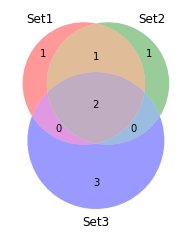

In [ ]:
set1 = set(['A', 'B', 'C', 'D'])
set2 = set(['B', 'C', 'D', 'E'])
set3 = set(['C', 'D',' E', 'F', 'G'])

venn3([set1, set2, set3], ('Set1', 'Set2', 'Set3'))
plt.show()

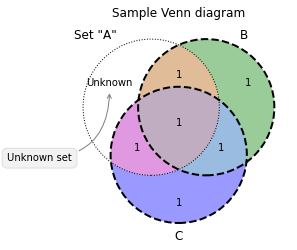

In [ ]:
plt.figure(figsize=(4,4))
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))
v.get_patch_by_id('100').set_alpha(1.0)
v.get_patch_by_id('100').set_color('white')
v.get_label_by_id('100').set_text('Unknown')
v.get_label_by_id('A').set_text('Set "A"')
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
c[0].set_lw(1.0)
c[0].set_ls('dotted')
plt.title("Sample Venn diagram")
plt.annotate('Unknown set', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()

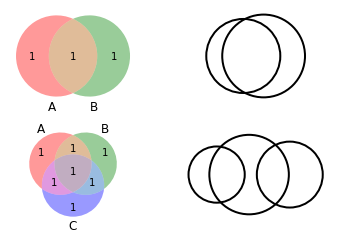

In [ ]:
figure, axes = plt.subplots(2, 2)
venn2(subsets={'10': 1, '01': 1, '11': 1}, set_labels = ('A', 'B'), ax=axes[0][0])
venn2_circles((1, 2, 3), ax=axes[0][1])
venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'), ax=axes[1][0])
venn3_circles({'001': 10, '100': 20, '010': 21, '110': 13, '011': 14}, ax=axes[1][1])
plt.show()